In [0]:
! curl -s https://course.fast.ai/setup/colab | bash
! pip install kaggle

Updating fastai...
Done.


In [0]:
! echo '{"username":"cclaypool","key":"a22edfb5d1cacf006cc8b57dcde458fe"}' > kaggle.json
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image
from tqdm import tqdm_notebook as tqdm

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## Preparing the Dataset

In [0]:
dataset_path = Config.data_path()/'seedlings'
dataset_path.mkdir(parents=True, exist_ok=True)
dataset_path

PosixPath('/root/.fastai/data/seedlings')

In [0]:
! kaggle competitions download -c plant-seedlings-classification -f train.zip -p {dataset_path}

train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
! unzip -q -n {dataset_path}/train.zip -d {dataset_path}

In [0]:
train_path = dataset_path/'train'

In [0]:
categories = sorted([f.name for f in train_path.ls()]); categories

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [0]:
valid_path = dataset_path/'valid'
valid_path.mkdir(exist_ok=True)
for category in categories:
  (valid_path/category).mkdir(exist_ok=True)

In [0]:
def show_num_samples(path):
  for category in categories:
    print('{0:<25} {1:>15}'.format(category + "", str(len((path/category).ls())) + " samples"))

In [0]:
show_num_samples(train_path)

Black-grass                   263 samples
Charlock                      390 samples
Cleavers                      287 samples
Common Chickweed              611 samples
Common wheat                  221 samples
Fat Hen                       475 samples
Loose Silky-bent              654 samples
Maize                         221 samples
Scentless Mayweed             516 samples
Shepherds Purse               231 samples
Small-flowered Cranesbill     496 samples
Sugar beet                    385 samples


In [0]:
random.seed(42)
for category in categories:
  for file in (train_path/category).ls():
    if random.randint(1, 10) >= 8:
      shutil.move(file, valid_path/category/file.name)

In [0]:
show_num_samples(train_path)

Black-grass                   190 samples
Charlock                      279 samples
Cleavers                      191 samples
Common Chickweed              424 samples
Common wheat                  147 samples
Fat Hen                       319 samples
Loose Silky-bent              457 samples
Maize                         146 samples
Scentless Mayweed             379 samples
Shepherds Purse               170 samples
Small-flowered Cranesbill     350 samples
Sugar beet                    259 samples


In [0]:
show_num_samples(valid_path)

Black-grass                    73 samples
Charlock                      111 samples
Cleavers                       96 samples
Common Chickweed              187 samples
Common wheat                   74 samples
Fat Hen                       156 samples
Loose Silky-bent              197 samples
Maize                          75 samples
Scentless Mayweed             137 samples
Shepherds Purse                61 samples
Small-flowered Cranesbill     146 samples
Sugar beet                    126 samples


In [0]:
clean_data = ImageDataBunch.from_folder(dataset_path, 
  train='train', valid='valid', ds_tfms=get_transforms(), size=224, bs=48)
clean_data.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

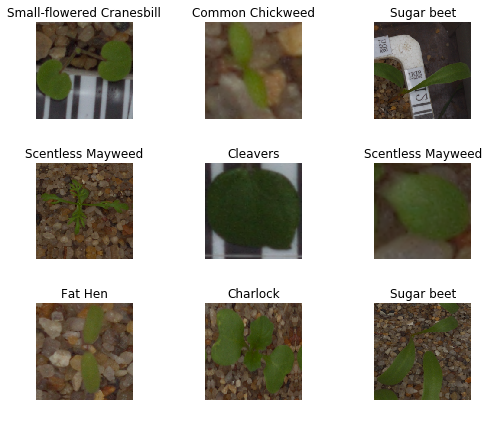

In [0]:
clean_data.show_batch(rows=3, figsize=(7,6))

## Training a Classifier

In [0]:
classifier_resnet34 = cnn_learner(clean_data, models.resnet34, metrics=error_rate)

In [0]:
classifier_resnet34.fit_one_cycle(16)

epoch,train_loss,valid_loss,error_rate,time
0,2.412446,1.588891,0.490618,01:40
1,1.631501,0.887924,0.289090,01:37
2,1.068575,0.612517,0.208478,01:36
3,0.765255,0.487102,0.172342,01:36
4,0.565815,0.362957,0.125087,01:36
5,0.454169,0.319607,0.096595,01:36
6,0.395818,0.299391,0.101459,01:35
7,0.344555,0.287225,0.100069,01:36
8,0.321700,0.267520,0.092425,01:35
9,0.274559,0.244122,0.090341,01:35


In [0]:
classifier_resnet34.save('resnet34')

## Training a Classifier: Results

In [0]:
interp_classifier_resnet34 = ClassificationInterpretation.from_learner(classifier_resnet34)

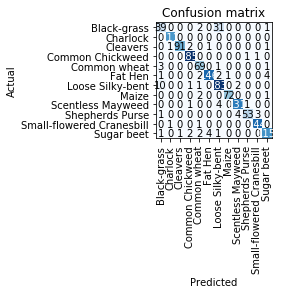

In [0]:
interp_classifier_resnet34.plot_confusion_matrix()

In [0]:
def accuracy_from_confusion_matrix(confusion_matrix):
  return confusion_matrix.diagonal().sum() / confusion_matrix.sum()

In [0]:
accuracy_from_confusion_matrix(interp_classifier_resnet34.confusion_matrix())

0.9305072967338429

## Generating Adversarial Examples (Untargeted, White-box)

In [0]:
def fast_gradient_sign(img, label, e, model):
  img.requires_grad = True
  out = model(img)
  loss = F.cross_entropy(out, label)
  loss.backward()
  s = img.grad.sign()
  img_adv = img + e * s
  return img_adv

In [0]:
adv_untargeted_valid_path = dataset_path/'valid_adv_untargeted'
adv_untargeted_valid_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_untargeted_valid_path/category).mkdir(exist_ok=True)
  for file in tqdm((valid_path/category).ls(), desc=category):
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([i]).cuda(),
                                           0.001,
                                           classifier_resnet34.model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_untargeted_valid_path/category/file.name)

In [0]:
data_adv_untargeted = ImageDataBunch.from_folder(dataset_path,
                                                 train='train',
                                                 valid = adv_untargeted_valid_path.name,
                                                 ds_tfms=get_transforms(),
                                                 size=224,
                                                 bs=48)
data_adv_untargeted.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

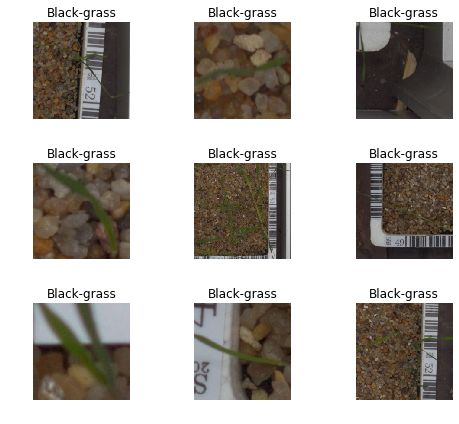

In [0]:
data_adv_untargeted.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Valid)

## Generating Adversarial Examples (Untargeted, White-box): Results


In [0]:
classifier_resnet34_adv_untargeted = cnn_learner(data_adv_untargeted,
                                                 models.resnet34,
                                                 metrics=error_rate,
                                                 pretrained=False)
classifier_resnet34_adv_untargeted.load('resnet34');

In [0]:
interp_resnet34_adv_untargeted = ClassificationInterpretation.from_learner(classifier_resnet34_adv_untargeted)

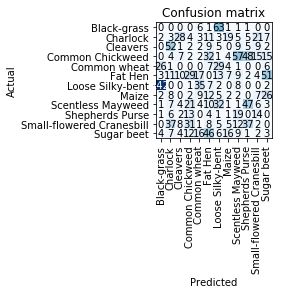

In [0]:
interp_resnet34_adv_untargeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_resnet34_adv_untargeted.confusion_matrix())

0.011118832522585128

## Generating Adversarial Examples (Targeted, White-box)

In [0]:
def fast_gradient_sign_targeted(img, label, e, model):
  img.requires_grad = True
  out = model(img)
  loss = F.cross_entropy(out, label)
  loss.backward()
  s = img.grad.sign()
  x_adv = img - e * s
  return x_adv

In [0]:
def fast_gradient_sign_targeted_it(img, label, e, it, model):
  for _ in range(it):
    x_adv = fast_gradient_sign_targeted(img, label, e, model)
    img = x_adv.detach()
  return x_adv

In [0]:
random.seed(12)
target_categories = []
for i in range(len(categories)):
  other_categories = list(range(12))
  other_categories.remove(i)
  target_categories.append(random.choice(other_categories))

In [0]:
target_categories

[8, 5, 11, 9, 11, 6, 2, 6, 0, 5, 7, 4]

In [0]:
adv_targeted_valid_path = dataset_path/'valid_adv_targeted'
adv_targeted_valid_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_targeted_valid_path/category).mkdir(exist_ok=True)
  print(category + ' -> ' + categories[target_categories[i]])
  for file in tqdm((valid_path/category).ls()):
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign_targeted_it(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([target_categories[i]]).cuda(),
                                           0.0002,
                                           40,
                                           classifier_resnet34.model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_targeted_valid_path/category/file.name)

Black-grass -> Scentless Mayweed


Charlock -> Fat Hen


Cleavers -> Sugar beet


Common Chickweed -> Shepherds Purse


Common wheat -> Sugar beet


Fat Hen -> Loose Silky-bent


Loose Silky-bent -> Cleavers


Maize -> Loose Silky-bent


Scentless Mayweed -> Black-grass


Shepherds Purse -> Fat Hen


Small-flowered Cranesbill -> Maize


Sugar beet -> Common wheat


In [0]:
data_adv_targeted = ImageDataBunch.from_folder(dataset_path,
                                               train='train',
                                               valid = adv_targeted_valid_path.name,
                                               ds_tfms=get_transforms(),
                                               size=224,
                                               bs=48)
data_adv_targeted.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

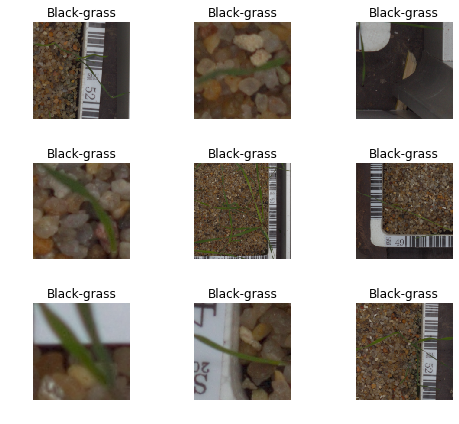

In [0]:
data_adv_targeted.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Valid)

## Generating Adversarial Examples (Targeted, White-box): Results


In [0]:
classifier_resnet34_adv_targeted = cnn_learner(data_adv_targeted,
                                               models.resnet34,
                                               metrics=error_rate,
                                               pretrained=False)
classifier_resnet34_adv_targeted.load('resnet34');

In [0]:
interp_resnet34_adv_targeted = ClassificationInterpretation.from_learner(classifier_resnet34_adv_targeted)

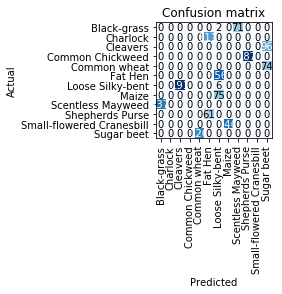

In [0]:
interp_resnet34_adv_targeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_resnet34_adv_targeted.confusion_matrix())

0.004169562195969423

In [0]:
target_categories

[8, 5, 11, 9, 11, 6, 2, 6, 0, 5, 7, 4]

In [0]:
def targeted_accuracy(interp):
  hits = 0
  for i in range(12):
    hits += interp.confusion_matrix()[i,target_categories[i]]
  return hits / interp.confusion_matrix().sum()

In [0]:
targeted_accuracy(interp_resnet34_adv_targeted)

0.9944405837387075

## Assessing the Transferability of the Generated Adversarial Examples

In [0]:
classifier_vgg16 = cnn_learner(clean_data, models.vgg16_bn, metrics=error_rate)

In [0]:
classifier_vgg16.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.191624,1.285735,0.403753,01:54
1,1.303915,0.608995,0.200139,01:54
2,0.825484,0.420203,0.144545,01:53
3,0.560778,0.323622,0.109798,01:52
4,0.438575,0.284652,0.093815,01:52
5,0.371405,0.248670,0.084086,01:53
6,0.319173,0.241808,0.079917,01:53
7,0.280977,0.238900,0.081306,01:53


In [0]:
classifier_vgg16.save('vgg16')

In [0]:
classifier_vgg16_adv_untargeted = cnn_learner(data_adv_untargeted,
                                              models.vgg16_bn,
                                              metrics=error_rate,
                                              pretrained=False)
classifier_vgg16_adv_untargeted.load('vgg16');

In [0]:
classifier_vgg16_adv_targeted = cnn_learner(data_adv_targeted,
                                            models.vgg16_bn,
                                            metrics=error_rate,
                                            pretrained=False)
classifier_vgg16_adv_targeted.load('vgg16');

In [0]:
classifier_densenet121 = cnn_learner(clean_data, models.densenet121, metrics=error_rate)

In [0]:
classifier_densenet121.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.805645,0.939989,0.275191,01:47
1,0.966908,0.396469,0.141765,01:46
2,0.565523,0.257678,0.084086,01:48
3,0.382333,0.202248,0.076442,01:46
4,0.283218,0.177989,0.069493,01:48
5,0.213332,0.159022,0.057679,01:47
6,0.178006,0.147447,0.051425,01:48
7,0.144156,0.147266,0.055594,01:48


In [0]:
classifier_densenet121.save('dn121');

In [0]:
classifier_densenet121_adv_untargeted = cnn_learner(data_adv_untargeted,
                                                    models.densenet121,
                                                    metrics=error_rate,
                                                    pretrained=False)
classifier_densenet121_adv_untargeted.load('dn121');

In [0]:
classifier_densenet121_adv_targeted = cnn_learner(data_adv_targeted,
                                                  models.densenet121,
                                                  metrics=error_rate,
                                                  pretrained=False)
classifier_densenet121_adv_targeted.load('dn121');

## Assessing the Transferability of the Generated Adversarial Examples: Results

In [0]:
interp_vgg16 = ClassificationInterpretation.from_learner(classifier_vgg16)

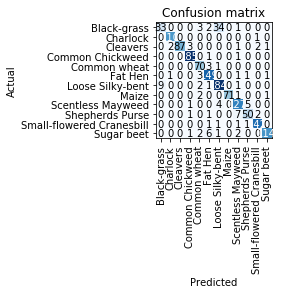

In [0]:
interp_vgg16.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_vgg16.confusion_matrix())

0.9186935371785963

In [0]:
interp_vgg16_adv_untargeted = ClassificationInterpretation.from_learner(classifier_vgg16_adv_untargeted)

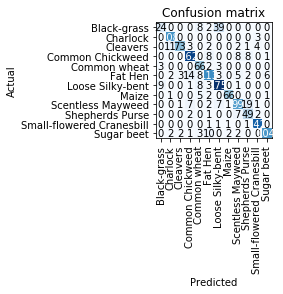

In [0]:
interp_vgg16_adv_untargeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_vgg16_adv_untargeted.confusion_matrix())

0.8207088255733148

In [0]:
interp_vgg16_adv_targeted = ClassificationInterpretation.from_learner(classifier_vgg16_adv_targeted)

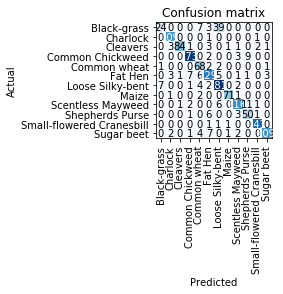

In [0]:
interp_vgg16_adv_targeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_vgg16_adv_targeted.confusion_matrix())

0.8735232800555942

In [0]:
targeted_accuracy(interp_vgg16_adv_targeted)

0.019457956914523976

In [0]:
interp_densenet121 = ClassificationInterpretation.from_learner(classifier_densenet121)

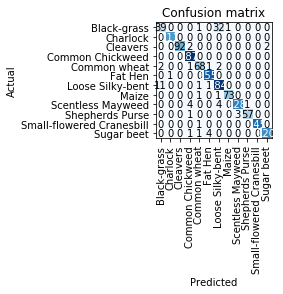

In [0]:
interp_densenet121.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_densenet121.confusion_matrix())

0.9444058373870744

In [0]:
interp_densenet_adv_untargeted = ClassificationInterpretation.from_learner(classifier_densenet121_adv_untargeted)

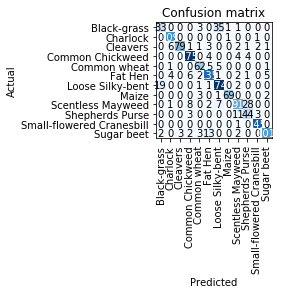

In [0]:
interp_densenet_adv_untargeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_densenet_adv_untargeted.confusion_matrix())

0.8457261987491314

In [0]:
interp_densenet_adv_targeted = ClassificationInterpretation.from_learner(classifier_densenet121_adv_targeted)

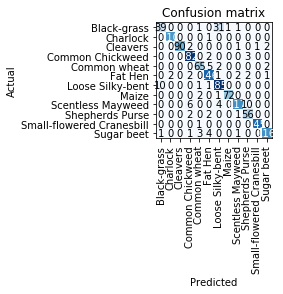

In [0]:
interp_densenet_adv_targeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_densenet_adv_targeted.confusion_matrix())

0.9193884642112579

In [0]:
targeted_accuracy(interp_densenet_adv_targeted)

0.011118832522585128

## Improving the Transferability of Generated Adversarial Examples

In [0]:
class EnsembleNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.resnet34 = classifier_resnet34.model
    self.vgg16 = classifier_vgg16.model
    self.densenet121 = classifier_densenet121.model
    
  def forward(self, input):
    out_resnet34 = self.resnet34(input)
    out_vgg16 = self.vgg16(input)
    out_densenet121 = self.densenet121(input)
    return (out_resnet34 + out_vgg16 + out_densenet121) / 3

In [0]:
ensemble_model = EnsembleNet()

In [0]:
adv_untargeted_e_valid_path = dataset_path/'valid_adv_untargeted_e'
adv_untargeted_e_valid_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_untargeted_e_valid_path/category).mkdir(exist_ok=True)
  for file in tqdm((valid_path/category).ls(), desc=category):
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([i]).cuda(),
                                           0.0005,
                                           ensemble_model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_untargeted_e_valid_path/category/file.name)

In [0]:
data_adv_untargeted_e = ImageDataBunch.from_folder(dataset_path,
                                                   train='train',
                                                   valid=adv_untargeted_e_valid_path.name,
                                                   ds_tfms=get_transforms(),
                                                   size=224,
                                                   bs=48)
data_adv_untargeted_e.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

In [0]:
classifier_resnet34_adv_untargeted_e = cnn_learner(data_adv_untargeted_e,
                                                   models.resnet34,
                                                   metrics=error_rate,
                                                   pretrained=False)
classifier_resnet34_adv_untargeted_e.load('resnet34');

In [0]:
classifier_vgg16_adv_untargeted_e = cnn_learner(data_adv_untargeted_e,
                                                 models.vgg16_bn,
                                                 metrics=error_rate,
                                                 pretrained=False)
classifier_vgg16_adv_untargeted_e.load('vgg16');

In [0]:
classifier_densenet121_adv_untargeted_e = cnn_learner(data_adv_untargeted_e,
                                                      models.densenet121,
                                                      metrics=error_rate,
                                                      pretrained=False)
classifier_densenet121_adv_untargeted_e.load('dn121');

In [0]:
classifier_resnet50 = cnn_learner(clean_data, models.resnet50, metrics=error_rate)

In [0]:
classifier_resnet50.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.518615,0.696576,0.232801,01:49
1,0.828608,0.353467,0.127172,01:48
2,0.522105,0.297074,0.106324,01:47
3,0.362662,0.243041,0.082001,01:47
4,0.277024,0.207511,0.071577,01:47
5,0.226484,0.196880,0.061848,01:47


In [0]:
classifier_resnet50.save('resnet50')

In [0]:
classifier_resnet50_adv_untargeted = cnn_learner(data_adv_untargeted,
                                                    models.resnet50,
                                                    metrics=error_rate,
                                                    pretrained=False)
classifier_resnet50_adv_untargeted.load('resnet50');

In [0]:
classifier_resnet50_adv_untargeted_e = cnn_learner(data_adv_untargeted_e,
                                                   models.resnet50,
                                                   metrics=error_rate,
                                                   pretrained=False)
classifier_resnet50_adv_untargeted_e.load('resnet50');

## Improving the Transferability of Generated Adversarial Examples: Results

In [0]:
interp_resnet34_adv_untargeted_e = ClassificationInterpretation.from_learner(classifier_resnet34_adv_untargeted_e)

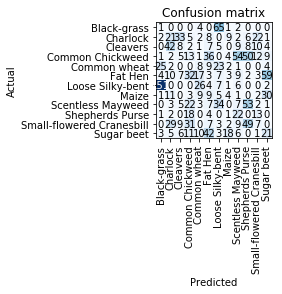

In [0]:
interp_resnet34_adv_untargeted_e.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_resnet34_adv_untargeted_e.confusion_matrix())

0.06949270326615706

In [0]:
interp_vgg16_adv_untargeted_e = ClassificationInterpretation.from_learner(classifier_vgg16_adv_untargeted_e)

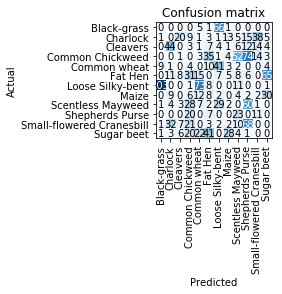

In [0]:
interp_vgg16_adv_untargeted_e.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_vgg16_adv_untargeted_e.confusion_matrix())

0.0

In [0]:
interp_densenet121_adv_untargeted_e = ClassificationInterpretation.from_learner(classifier_densenet121_adv_untargeted_e)

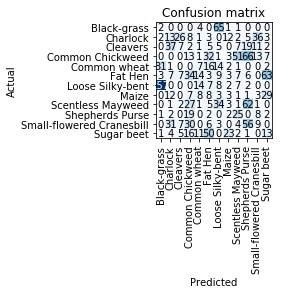

In [0]:
interp_densenet121_adv_untargeted_e.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_densenet121_adv_untargeted_e.confusion_matrix())

0.05489923558026407

In [0]:
interp_resnet50_adv_untargeted = ClassificationInterpretation.from_learner(classifier_resnet50_adv_untargeted)

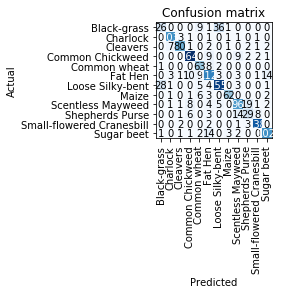

In [0]:
interp_resnet50_adv_untargeted.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_resnet50_adv_untargeted.confusion_matrix())

0.7852675469075747

In [0]:
interp_resnet50_adv_untargeted_e = ClassificationInterpretation.from_learner(classifier_resnet50_adv_untargeted_e)

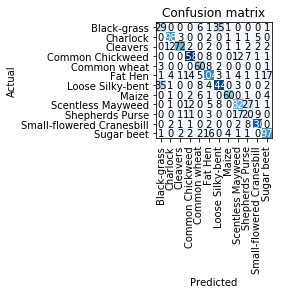

In [0]:
interp_resnet50_adv_untargeted_e.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_resnet50_adv_untargeted_e.confusion_matrix())

0.7324530924252953

## Defending Against Adversarial Examples: Training on Adversarial Images

In [0]:
adv_untargeted_train_path = dataset_path/'train_adv_untargeted'
adv_untargeted_train_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_untargeted_train_path/category).mkdir(exist_ok=True)
  for file in tqdm((train_path/category).ls(), desc=category):
    shutil.copyfile(file, adv_untargeted_train_path/category/file.name)
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([i]).cuda(),
                                           0.0005,
                                           classifier_resnet34.model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_untargeted_train_path/category/('adv'+file.name))

In [0]:
show_num_samples(adv_untargeted_train_path)

Black-grass                   380 samples
Charlock                      558 samples
Cleavers                      382 samples
Common Chickweed              848 samples
Common wheat                  294 samples
Fat Hen                       638 samples
Loose Silky-bent              914 samples
Maize                         292 samples
Scentless Mayweed             758 samples
Shepherds Purse               340 samples
Small-flowered Cranesbill     700 samples
Sugar beet                    518 samples


In [0]:
data_train_adv_untargeted = ImageDataBunch.from_folder(dataset_path,
                                                       train='train_adv_untargeted',
                                                       valid='valid_adv_untargeted',
                                                       ds_tfms=get_transforms(),
                                                       size=224,
                                                       bs=48)
data_train_adv_untargeted.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

In [0]:
classifier_resnet34_train_adv_untargeted = cnn_learner(data_train_adv_untargeted,
                                                       models.resnet34,
                                                       metrics=error_rate)

In [0]:
classifier_resnet34_train_adv_untargeted.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.870776,2.317155,0.782488,01:59
1,1.118410,2.348382,0.755386,01:59
2,0.791641,2.104018,0.678944,01:59
3,0.619517,1.969791,0.628909,01:59
4,0.505185,1.819433,0.581654,01:59
5,0.431195,1.703422,0.560111,01:59
6,0.360497,1.653044,0.553857,01:59
7,0.329481,1.645283,0.537179,01:57


In [0]:
classifier_resnet34_train_adv_untargeted.save('r34-adv')

In [0]:
classifier_resnet34_train_adv_untargeted.unfreeze()
classifier_resnet34_train_adv_untargeted.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


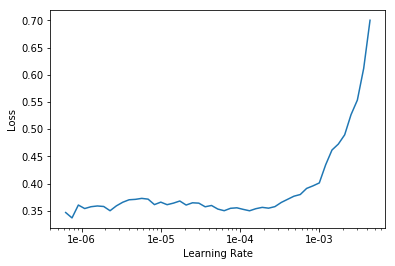

In [0]:
classifier_resnet34_train_adv_untargeted.recorder.plot()

In [0]:
classifier_resnet34_train_adv_untargeted.fit_one_cycle(20, slice(3e-6, 5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.322823,1.632367,0.528839,02:04
1,0.311734,1.576342,0.519805,02:02
2,0.309219,1.482525,0.503127,02:03
3,0.279063,1.339798,0.456567,02:04
4,0.228404,1.224715,0.413482,02:04
5,0.198590,1.105657,0.370396,02:04
6,0.160481,1.001995,0.342599,02:03
7,0.135286,0.938145,0.314107,02:03
8,0.106285,0.851058,0.285615,02:05
9,0.090223,0.820406,0.266852,02:03


In [0]:
classifier_resnet34_train_adv_untargeted.fit_one_cycle(20, slice(3e-6, 5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.039838,0.674920,0.216817,02:04
1,0.036653,0.700747,0.220292,02:03
2,0.028350,0.702757,0.220987,02:05
3,0.031981,0.713795,0.222377,02:06
4,0.031615,0.661515,0.213343,02:05
5,0.028658,0.703750,0.204309,02:04
6,0.026745,0.618314,0.187630,02:04
7,0.025445,0.605817,0.177901,02:05
8,0.017973,0.641139,0.184156,02:05
9,0.014517,0.578458,0.164698,02:05


In [0]:
classifier_resnet34_train_adv_untargeted.fit_one_cycle(20, slice(3e-6, 5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.008748,0.561670,0.161918,02:02
1,0.006592,0.551359,0.154969,02:02
2,0.009509,0.566927,0.158443,02:04
3,0.007766,0.560591,0.159138,02:04
4,0.010239,0.557230,0.147325,02:04
5,0.011380,0.553411,0.154969,02:04
6,0.010583,0.547203,0.154969,02:03
7,0.006563,0.565402,0.152884,02:02
8,0.008961,0.553419,0.149409,02:02
9,0.006559,0.531775,0.140375,02:03


In [0]:
classifier_resnet34_train_adv_untargeted.save('r34-adv')

In [0]:
data_train_adv_untargeted_s = ImageDataBunch.from_folder(dataset_path,
                                                         train='train_adv_untargeted',
                                                         valid='valid',
                                                         ds_tfms=get_transforms(),
                                                         size=224,
                                                         bs=48)
data_train_adv_untargeted_s.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

In [0]:
adv_untargeted_t_valid_path = dataset_path/'valid_adv_untargeted_t'
adv_untargeted_t_valid_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_untargeted_t_valid_path/category).mkdir(exist_ok=True)
  for file in tqdm((valid_path/category).ls(), desc=category):
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([i]).cuda(),
                                           0.0005,
                                           classifier_resnet34_train_adv_untargeted.model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_untargeted_t_valid_path/category/file.name)

In [0]:
data_train_adv_untargeted_t = ImageDataBunch.from_folder(dataset_path,
                                                         train='train',
                                                         valid='valid_adv_untargeted_t',
                                                         ds_tfms=get_transforms(),
                                                         size=224,
                                                         bs=48)
data_train_adv_untargeted_t.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

## Defending Against Adversarial Examples: Training on Adversarial Images: Results

In [0]:
interp = ClassificationInterpretation.from_learner(classifier_resnet34_train_adv_untargeted)

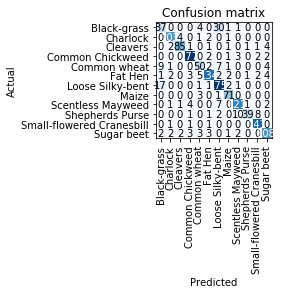

In [0]:
interp.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp.confusion_matrix())

0.8637943015983321

In [0]:
classifier_resnet34_train_adv_untargeted_s = cnn_learner(data_train_adv_untargeted_s,
                                                         models.resnet34,
                                                         metrics=error_rate)
classifier_resnet34_train_adv_untargeted_s.load('r34-adv');

In [0]:
interp = ClassificationInterpretation.from_learner(classifier_resnet34_train_adv_untargeted_s)

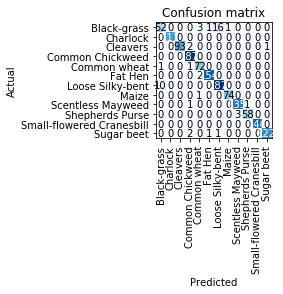

In [0]:
interp.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp.confusion_matrix())

0.9666435024322446

In [0]:
classifier_resnet34_train_adv_untargeted_t = cnn_learner(data_train_adv_untargeted_t,
                                                         models.resnet34,
                                                         metrics=error_rate)
classifier_resnet34_train_adv_untargeted_t.load('r34-adv');

In [0]:
interp_t = ClassificationInterpretation.from_learner(classifier_resnet34_train_adv_untargeted_t)

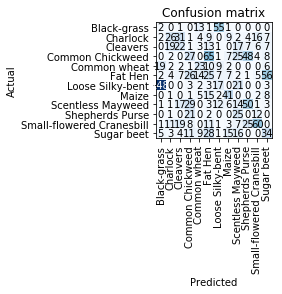

In [0]:
interp_t.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp_t.confusion_matrix())

0.20222376650451704

In [0]:
adv_untargeted_rf_valid_path = dataset_path/'valid_adv_untargeted_rf'
adv_untargeted_rf_valid_path.mkdir(exist_ok=True)
for i, category in enumerate(categories):
  (adv_untargeted_rf_valid_path/category).mkdir(exist_ok=True)
  for file in tqdm((valid_path/category).ls(), desc=category):
    img = Image.open(file).convert('RGB')
    img_as_tensor = TF.normalize(TF.to_tensor(TF.resize(img, 224)), 
                                 (0.5, 0.5, 0.5), 
                                 (0.5, 0.5, 0.5))
    img_adv_as_tensor = fast_gradient_sign(img_as_tensor.unsqueeze(0).cuda(), 
                                           torch.tensor([i]).cuda(),
                                           0.005,
                                           classifier_resnet50.model)
    img_adv = TF.to_pil_image(img_adv_as_tensor.squeeze().detach().cpu() * 0.5 + 0.5)
    img_adv.save(adv_untargeted_rf_valid_path/category/file.name)

In [0]:
data_rf = ImageDataBunch.from_folder(dataset_path, train='train', valid=adv_untargeted_rf_valid_path.name,
                        ds_tfms=get_transforms(), size=224, bs=48)
data_rf.normalize(([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]));

In [0]:
classifier_rf = cnn_learner(data_rf, models.resnet50, metrics=error_rate, pretrained=False)
classifier_rf.load('resnet50');

In [0]:
interp = ClassificationInterpretation.from_learner(classifier_resnet50)

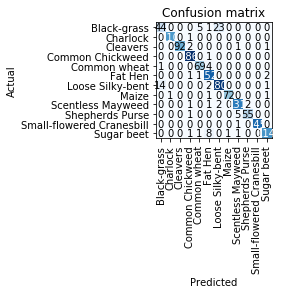

In [0]:
interp.plot_confusion_matrix()

In [0]:
accuracy_from_confusion_matrix(interp.confusion_matrix())

0.9381514940931203